# Setup

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
from datetime import datetime
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import RegressorChain
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import warnings
warnings.filterwarnings("ignore")

## Utils

In [2]:
def create_timeseries_data(county = "Philadelphia"):
    incidents_df = pd.read_csv('../data/Aggregated/incidents.csv')
    
    incidents_df = incidents_df[incidents_df['Incident County Name'] == county]
    
    incidents_df['Month'] = incidents_df['Incident Date'].apply(lambda x: pd.Timestamp(datetime.strptime(x,"%m/%d/%Y")).month)
    
    incidents_df["Fentanyl"] = incidents_df["All Drugs"].apply(lambda x: 1 if "FENTANYL" in x else 0)
    
    incidents_df["Heroin"] = incidents_df["All Drugs"].apply(lambda x: 1 if "HEROIN" in x else 0)
    
    incidents_df["Year"] = incidents_df["Incident Date"].apply(lambda x: datetime.strptime(x,"%m/%d/%Y").year)
    
    incidents_df['Count'] = 1

    return incidents_df


"""Credit to Marco Peixiero:
https://towardsdatascience.com/the-complete-guide-to-time-series-forecasting-using-sklearn-pandas-and-numpy-7694c90e45c1
"""
def window_input_output(input_length: int, output_length: int, data: pd.DataFrame) -> pd.DataFrame:
    
    df = data.copy()
    
    for i in range(1, input_length):
        df[f'x_{i}'] = df['Count'].shift(-i)
    
    for i in range(output_length):
        df[f'y_{i}'] = df['Count'].shift(-output_length-i)
    
    df = df.dropna(axis=0)
    
    return df

# Sanity Check
# _ = window_input_output(2, 2, time_series_df[["Count"]])


def split_data(df, forcast = 5, test_size = 1):
    
    # Create lags 
    final_df = window_input_output(forcast, forcast, df)
    
    # Extract features and targets
    feature_cols = [col for col in final_df.columns if col.startswith('x') or col == "Count"]
    target_cols = [col for col in final_df.columns if col.startswith('y')]
    
    # Split data according to test_size
    x_train = final_df[feature_cols][:-test_size].values
    y_train = final_df[target_cols][:-test_size].values

    x_test = final_df[feature_cols][-test_size:].values
    y_test = final_df[target_cols][-test_size:].values
    
    return x_train, x_test, y_train, y_test, final_df

def fill_missing_months(df,
                        start_year = 2018,
                        end_year = 2022,
                        start_month = 1,
                        end_month = 12):
    
    # Ensure input has both month and year
    if "Year" not in df.columns or "Month" not in df.columns:
        raise ValueError("Missing one or more columns")
    
    # Copy dataframe
    temp_df = df.copy()
    
    # Find months that are missing in the set of dataframe
    years = [i for i in range(start_year, end_year + 1)]
    months = [i for i in range(start_month, end_month + 1)]
    
    # Complete Set of all combinations of years and months in the range required
    combination_ls = set([y * 100 + m for y in years for m in months])
    
    # Set of months and years presented in the dataframe
    a = set(temp_df[["Year", "Month"]].apply(lambda x: x["Year"] * 100 + x["Month"], axis = 1).tolist())
    
    # Missing pieces
    missing_months = combination_ls - a
    
    # Append missing months to dataframe
    for period in missing_months:
        month = period % 100
        year = period // 100
        county = time_series_df["County"].unique()[0]
        temp_df = temp_df.append({'County': county,
                                  'Year': year,
                                  'Month': month,
                                  'Count' : 0}, ignore_index = True)
    
    
    return temp_df.sort_values(by = ["Year", "Month"])


def df_with_timestamp(df):
    
    temp_df = df.copy()
    temp_df["Date"] = temp_df.apply(lambda x: datetime(year = x["Year"], month = x["Month"], day = 1), axis = 1)
    return temp_df.set_index("Date")


def plot_forecast(orig_df,
                  final_df,
                  x_train,
                  x_test,
                  y_train,
                  y_test,
                  fitted_estimators = [],
                  forcast = 5):
    
    ts_df = df_with_timestamp(orig_df[["Year", "Month", "Count"]])
    test_timestamp = [ts_df.index.tolist()[-forcast* 2 +1: -forcast], ts_df.index.tolist()[-forcast: ]]
    
    input_ts_ls = ts_df.iloc[:len(x_train) + 1,].index.tolist()
    input_ts_ls.extend(test_timestamp[0])

    input_count_ls = [i[0] for i in x_train]
    input_count_ls.extend(x_test[0])
    
    # Plot data 
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(input_ts_ls, input_count_ls, marker='P', color='blue', label='Input')
    ax.plot(test_timestamp[1], y_test[0], marker='P', color='red', label='Actual')
    
    # Plot predicted values for each estimator
    for est in fitted_estimators:
        name = str(est.estimators_[0].__class__).split(".")[-1][:-2]
        preds = est.predict(x_test)
        ax.plot(test_timestamp[1], preds[0], marker='P', label=f'{name}')
        print(f"RMSE {name}: {sqrt(mean_squared_error(y_test, preds)):.2f}")
    
    plt.legend() 

# Read Datasets

In [3]:
time_series_df = create_timeseries_data()

## Data preprocessing

In [4]:
ls = ["Incident County Name",
      "Month",
      "Year",
      "Count"]

time_series_df = time_series_df[ls]
time_series_df = time_series_df.groupby(['Incident County Name',
                                         'Year',
                                         'Month']).sum().reset_index()
time_series_df.rename(columns={'Incident County Name': 'County'}, inplace=True)

time_series_df = fill_missing_months(time_series_df)

# Sanity Check
# test[(test['County'] == 'Philadelphia')]

## Time Series Forcasting

In [5]:
forcast = 5
test_size = 1
(x_train,
 x_test,
 y_train,
 y_test,
 final_df) = split_data(time_series_df[:-1], forcast = forcast, test_size = test_size) # -1 is to remove Jan 2023

## Decision Tree Regressor

In [6]:
dtr_seq = DecisionTreeRegressor(criterion = "absolute_error",
                                max_depth = 1,
                                random_state=42)
chained_dtr = RegressorChain(dtr_seq)
chained_dtr.fit(x_train, y_train)
dtr_seq_preds = chained_dtr.predict(x_test)

sqrt(mean_squared_error(y_test, dtr_seq_preds))

17.068977708111287

## Random Forest Regressor

In [7]:
rfr_seq = RandomForestRegressor(criterion = "friedman_mse",
                                max_depth = 1,
                                random_state = 42)
chained_rfr = RegressorChain(rfr_seq)
chained_rfr.fit(x_train, y_train)
rfr_seq_preds = chained_rfr.predict(x_test)

sqrt(mean_squared_error(y_test, rfr_seq_preds))

16.572499182836435

In [8]:

gbr_seq = GradientBoostingRegressor(loss = "absolute_error",
                                    learning_rate = 0.1,
                                    random_state=42)
chained_gbr = RegressorChain(gbr_seq)
chained_gbr.fit(x_train, y_train)
gbr_seq_preds = chained_gbr.predict(x_test)
sqrt(mean_squared_error(y_test, gbr_seq_preds))

21.150901834268772

## Plots

RMSE RandomForestRegressor: 16.57
RMSE GradientBoostingRegressor: 21.15
RMSE DecisionTreeRegressor: 17.07


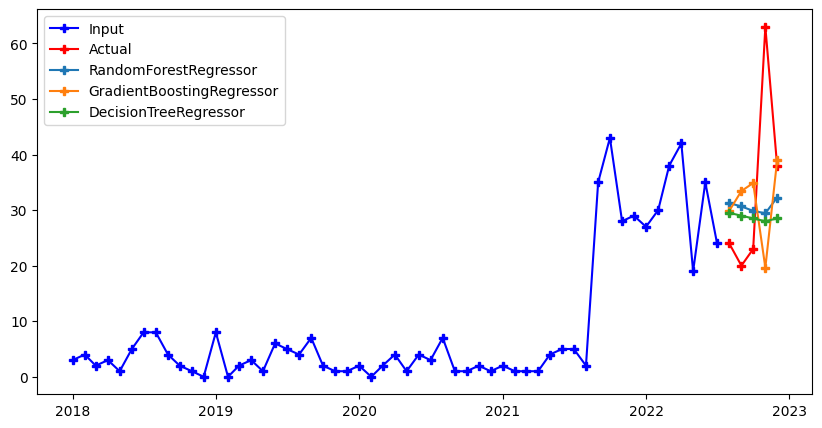

In [9]:
plot_forecast(orig_df = time_series_df[:-1],
              final_df = final_df,
              x_train = x_train,
              x_test = x_test,
              y_train = y_train,
              y_test = y_test,
              fitted_estimators = [chained_rfr,
                                   chained_gbr,
                                   chained_dtr])

## Prediction to 2024

In [10]:
def append_row(df):
    
    # Create a copy of df and last row in df
    temp_df = df.copy()
    temp_row = temp_df.iloc[-1:, :].copy()
    
    # Shift all values to the left
    for i in range(1,temp_row.shape[1]):
        temp_row.iloc[0,i - 1] = temp_row.iloc[0,i]
    
    # Set last column to NaN (to be predicted)
    temp_row.iloc[0, -1] = np.nan
    
    # Replace timestamp with the following month
    temp_row = temp_row.rename(index={temp_row.index[0]: temp_row.index[0] + relativedelta(months = 1)})
    
    # Append new row to dataframe
    temp_df = temp_df.append(temp_row)
    
    return temp_df

# Sanity Check
# append_row(final_df)

In [11]:
def pred_to_year(fitted_estimator,
                 orig_df,
                 year = 2024,
                 month = 1,
                 forcast = 5,
                 test_size = 1):
    (x_train,
     x_test,
     y_train,
     y_test,
     temp_df) = split_data(orig_df[:-1], forcast = forcast, test_size = test_size)
    temp_df = df_with_timestamp(temp_df)
    temp_df.drop(["County", "Year", "Month"], axis = 1, inplace = True)
    
    threshold = datetime(year = year, month = month, day = 1)
    while temp_df.iloc[-1:,:].index[0] < threshold:
        temp_df = append_row(temp_df)
        iter_test = temp_df.iloc[-1:, : 5]
        preds = fitted_estimator.predict(iter_test)
        temp_df.iloc[-1, -1] = preds[0][-1]
    
    return temp_df
    
    

In [12]:
_ = pred_to_year(chained_gbr, time_series_df[:-1])
_

,Count,x_1,x_2,x_3,x_4,y_0,y_1,y_2,y_3,y_4
Date,,,,,,,,,,
2018-01-01,3.000000,4.000000,2.000000,3.000000,1.000000,5.000000,8.000000,8.000000,4.000000,2.000000
2018-02-01,4.000000,2.000000,3.000000,1.000000,5.000000,8.000000,8.000000,4.000000,2.000000,1.000000
2018-03-01,2.000000,3.000000,1.000000,5.000000,8.000000,8.000000,4.000000,2.000000,1.000000,0.000000
2018-04-01,3.000000,1.000000,5.000000,8.000000,8.000000,4.000000,2.000000,1.000000,0.000000,8.000000
2018-05-01,1.000000,5.000000,8.000000,8.000000,4.000000,2.000000,1.000000,0.000000,8.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2023-09-01,28.793333,28.280378,30.524562,26.951484,29.294893,27.677182,35.944936,38.157132,26.461296,24.547882
2023-10-01,28.280378,30.524562,26.951484,29.294893,27.677182,35.944936,38.157132,26.461296,24.547882,24.609560
2023-11-01,30.524562,26.951484,29.294893,27.677182,35.944936,38.157132,26.461296,24.547882,24.609560,28.444564


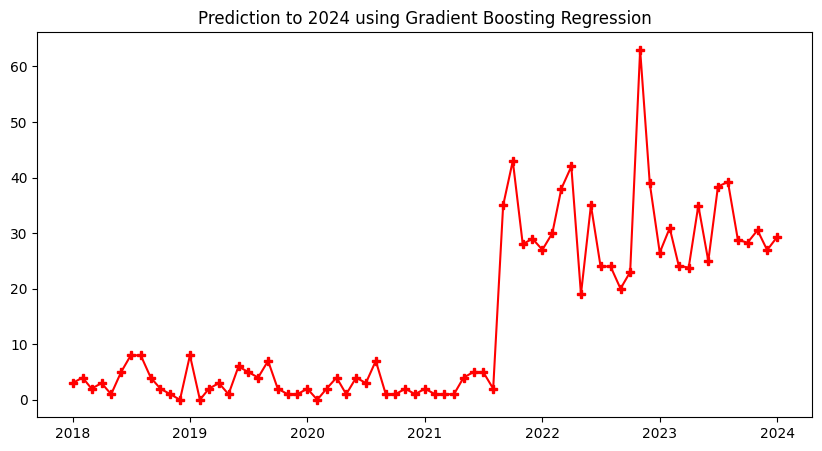

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.title("Prediction to 2024 using Gradient Boosting Regression")
ax.plot(_.index, _["Count"], marker='P', color='red')

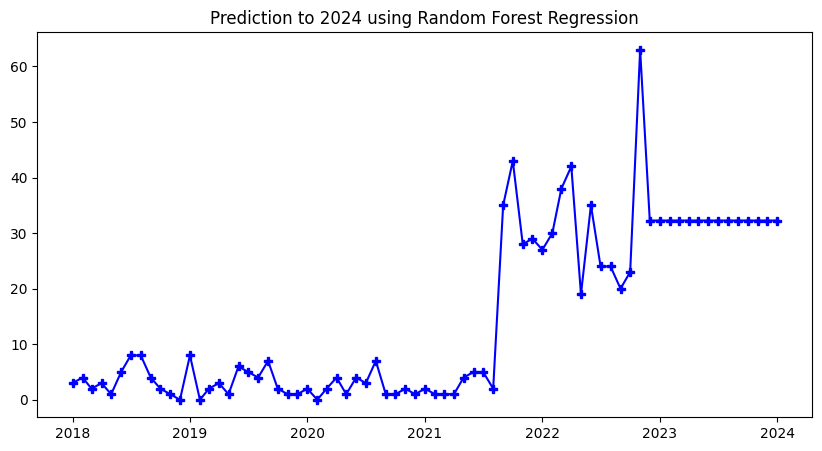

In [14]:
_ = pred_to_year(chained_rfr, time_series_df[:-1])
fig, ax = plt.subplots(figsize=(10, 5))
plt.title("Prediction to 2024 using Random Forest Regression")
ax.plot(_.index, _["Count"], marker='P', color='blue',)